Iteration 0 | Loss = 9.487350e-02
Iteration 500 | Loss = 5.672273e-03
Iteration 1000 | Loss = 1.439193e-03
Iteration 1500 | Loss = 4.418041e-04
Iteration 2000 | Loss = 3.079658e-04
Iteration 2500 | Loss = 1.780192e-04
Iteration 3000 | Loss = 1.386896e-04
Iteration 3500 | Loss = 1.463442e-04
Iteration 4000 | Loss = 4.171977e-04
Iteration 4500 | Loss = 1.023207e-04


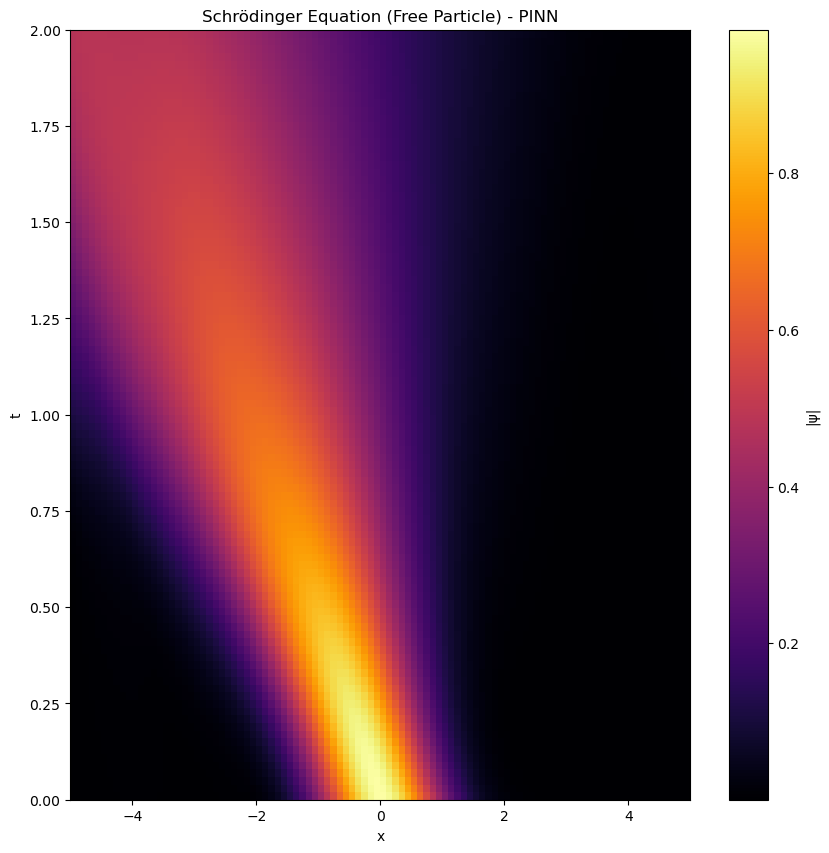

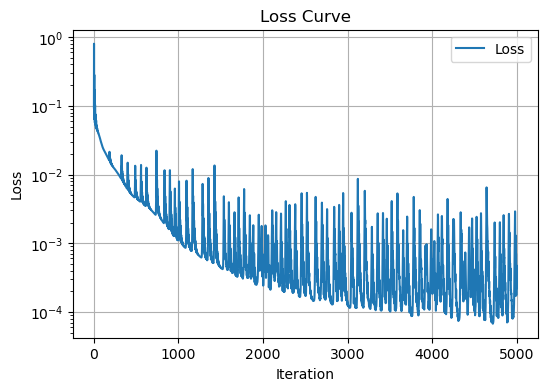

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Planck's constant set to 1 (natural units)
hbar = tf.constant(1.0, dtype=tf.float32) 
# Particle mass set to 1 (natural units)
m    = tf.constant(1.0, dtype=tf.float32)  

# Spatial domain boundaries
x_min, x_max = -5.0, 5.0
# Temporal domain boundaries
t_min, t_max = 0.0, 2.0

# Number of points in space and time
N_x, N_t = 100, 100

# Create training grid for x and t, both as float32 arrays ( this give me problem in my code ) 
x_train = np.linspace(x_min, x_max, N_x).astype(np.float32)
t_train = np.linspace(t_min, t_max, N_t).astype(np.float32)

# Create meshgrid: 
#   X[i,j] = x_train[j], T[i,j] = t_train[i]
#   So that rows correspond to fixed t and columns to fixed x
X, T    = np.meshgrid(x_train, t_train)  # X.shape = (N_t, N_x), T.shape = (N_t, N_x)

# Flatten the meshgrid into a (N_t * N_x, 2) array: columns are [x, t]
XT_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_train_tensor = tf.convert_to_tensor(XT_train, dtype=tf.float32)

# Define the initial wavefunction ψ(x,0) = exp(-x^2) * exp(i * k * x)
def psi_0(x):
    """Return the complex initial wavefunction at position x."""
    k = 2.0
    return np.exp(-x**2) * np.exp(1j * k * x)

# Compute initial condition on the spatial grid x_train
psi_init      = psi_0(x_train)  # Complex128 array from NumPy
# Separate into real and imaginary parts, cast to float32
psi_init_real = psi_init.real.astype(np.float32)  # real part
psi_init_imag = psi_init.imag.astype(np.float32)  # imaginary part

# Stack real and imaginary parts into a (N_x, 2) array: columns are [Re(ψ), Im(ψ)] 
#( litlle trick of you want to write ɸ juste touch Ctrl + Cmd + Espace and write phi )  
psi_initial_tensor = tf.convert_to_tensor(
    np.column_stack([psi_init_real, psi_init_imag]),
    dtype=tf.float32
)

# Build a neural network: inputs are (x, t) pairs; outputs are [Re(ψ), Im(ψ)]
inputs  = tf.keras.Input(shape=(2,))
hidden  = tf.keras.layers.Dense(35, activation="tanh")(inputs)
hidden  = tf.keras.layers.Dense(35, activation="tanh")(hidden)
hidden  = tf.keras.layers.Dense(35, activation="tanh")(hidden)
# Final layer has 2 neurons: one for the real part, one for the imaginary part
outputs = tf.keras.layers.Dense(2)(hidden)  # [psi_real, psi_imag]
model   = tf.keras.Model(inputs, outputs)

# Define the PINN loss function. We enforce the free Schrödinger equation:
# i ∂ψ/∂t + (ħ^2 / (2m)) ∂^2ψ/∂x^2 = 0
# Split into real and imaginary parts. If ψ = ψ_real + i ψ_imag, then:
# i ∂t(ψ_real + i ψ_imag)
# = i ∂ψ_real/∂t + i^2 ∂ψ_imag/∂t
# = i ∂ψ_real/∂t -      ∂ψ_imag/∂t
#
# PDE becomes: i ∂ψ/∂t + (ħ^2/(2m)) ∂²ψ/∂x² = 0
# Separate into two real equations:
#   (1) ∂ψ_imag/∂t + (ħ^2 / (2m)) ∂²ψ_real/∂x² = 0
#   (2) -∂ψ_real/∂t + (ħ^2 / (2m)) ∂²ψ_imag/∂x² = 0

@tf.function
def pinn_loss(XT):
    # Use GradientTape to compute first- and second-order derivatives w.r.t. inputs (x,t)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(XT)

        # Forward pass: network predicts [ψ_real, ψ_imag] for each (x,t) in XT
        psi = model(XT)  # shape (N_t * N_x, 2)
        psi_real = psi[:, 0:1]  # shape (N_t * N_x, 1)
        psi_imag = psi[:, 1:2]  # shape (N_t * N_x, 1)

        # First-order derivatives of real and imaginary parts w.r.t. t and x
        # Note: tape.gradient returns gradient of psi_real w.r.t. XT (shape matches XT),
        # so gradient[:, 1:2] is ∂ψ_real/∂t, gradient[:, 0:1] is ∂ψ_real/∂x.
        dpsi_real_dt = tape.gradient(psi_real, XT)[:, 1:2]  # ∂ψ_real/∂t
        dpsi_real_dx = tape.gradient(psi_real, XT)[:, 0:1]  # ∂ψ_real/∂x
        dpsi_imag_dt = tape.gradient(psi_imag, XT)[:, 1:2]  # ∂ψ_imag/∂t
        dpsi_imag_dx = tape.gradient(psi_imag, XT)[:, 0:1]  # ∂ψ_imag/∂x

        # Second-order derivatives w.r.t. x
        d2psi_real_dx2 = tape.gradient(dpsi_real_dx, XT)[:, 0:1]  # ∂²ψ_real/∂x²
        d2psi_imag_dx2 = tape.gradient(dpsi_imag_dx, XT)[:, 0:1]  # ∂²ψ_imag/∂x²

        # Compute the Schrödinger PDE residuals (for real and imaginary parts)
        schrodinger_eq_real = dpsi_imag_dt + (hbar**2 / (2.0 * m)) * d2psi_real_dx2
        schrodinger_eq_imag = -dpsi_real_dt + (hbar**2 / (2.0 * m)) * d2psi_imag_dx2

        # PDE loss = mean squared of both residuals
        loss_pde = tf.reduce_mean(tf.square(schrodinger_eq_real)) \
                 + tf.reduce_mean(tf.square(schrodinger_eq_imag))

        # Initial condition loss: compare network prediction at t=0 with ψ_initial_tensor
        # The first N_x rows of XT correspond to t = t_min = 0
        psi_ic_pred = model(XT[:N_x, :])  # shape (N_x, 2)
        loss_ic = tf.reduce_mean(tf.square(psi_ic_pred - psi_initial_tensor))

    # Total loss = PDE loss + initial condition loss
    return loss_pde + loss_ic

# Optimizer setup (Adam with learning rate 0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_history = []

# Training loop: minimize the PINN loss
for step in range(5000):
    with tf.GradientTape() as tape:
        loss_value = pinn_loss(XT_train_tensor)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    loss_history.append(loss_value.numpy())
    if step % 500 == 0:
        print(f"Iteration {step} | Loss = {loss_value.numpy():.6e}")

# After training, predict ψ_real and ψ_imag on the full grid (x,t)
psi_pred = model(XT_train_tensor).numpy()
psi_real_pred = psi_pred[:, 0].reshape(N_t, N_x)
psi_imag_pred = psi_pred[:, 1].reshape(N_t, N_x)

# Compute the modulus |ψ| = sqrt(ψ_real^2 + ψ_imag^2)
psi_modulus = np.sqrt(psi_real_pred**2 + psi_imag_pred**2)

# Plot |ψ(x,t)| as a heatmap
plt.figure(figsize=(10,10))
plt.imshow(psi_modulus,
           extent=[x_min, x_max, t_min, t_max],
           origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label="|ψ|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Schrödinger Equation (Free Particle) - PINN")
plt.show()

# Plot the training loss on a log scale
plt.figure(figsize=(6,4))
plt.plot(loss_history, label="Loss")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()